In [ ]:
# Load data from drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Import statements
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import scipy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset
from keras.callbacks import EarlyStopping
import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
import os
cwd = os.getcwd()
print(cwd)

/content


# Load data + cleaning

In [ ]:
df_list = []
for filename in glob.glob("/content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/*"):
  print("Processing " + filename)
  df = pd.read_pickle(filename)
  df_list.append(df)

all_data = pd.concat(df_list, axis=0)
all_data.count()

Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/1000-2000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/2000-3000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/3000-4000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/4000-5000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/5000-6000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/6000-7000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/0001-1000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/7000-8000_mfcc_EDA_data
Processing /content/drive/MyDrive/Colab Notebooks/Code for submission/ML Pickle Jar/8000-9000_mfcc_EDA_data
Processing /content/drive/My

filename              73465
text                  73465
up_votes              73465
down_votes            73465
age                   73465
gender                73465
accent                63163
mean_RMSE             73465
mean_spec_centroid    73465
mfcc                  73465
meanff                72999
q1                    73465
iqr                   73465
chroma                73465
mel                   73465
dtype: int64

In [ ]:
sound_data = all_data.copy()

In [ ]:
sound_data = sound_data.drop(columns=['up_votes','down_votes','text','accent'])
sound_data.head()

,filename,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
1000,cv-valid-train/sample-002750.mp3,thirties,male,0.025066,2333.515420,"[[-653.66547, -553.5895, -507.24734, -510.7036...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1001,cv-valid-train/sample-002756.mp3,fifties,female,0.086192,1875.045261,"[[-351.88895, -266.37778, -290.86395, -292.594...",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
1002,cv-valid-train/sample-002762.mp3,thirties,female,0.002153,3797.429451,"[[-854.9337, -840.2629, -825.6537, -820.5658, ...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
1003,cv-valid-train/sample-002763.mp3,seventies,male,0.009721,2595.827243,"[[-630.77386, -536.9595, -541.82056, -642.6946...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
1004,cv-valid-train/sample-002765.mp3,fourties,male,0.013881,2043.898864,"[[-736.3709, -693.187, -660.3091, -656.9877, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


In [ ]:
sound_data.reset_index(drop=True, inplace=True)

In [ ]:
# Remove unnecessary columns
sound_data.drop(sound_data[sound_data["gender"]=="other"].index, inplace=True)

In [ ]:
sound_data.drop(columns=["filename"], inplace=True)

In [ ]:
# Convert strings to numbers for classification
age_dict = {
    "teens": 0,
    "twenties": 1,
    "thirties": 2,
    "fourties": 3,
    "fifties": 4,
    "sixties": 5,
    "seventies": 6,
    "eighties": 7
}
gender_dict = {
    "male": 0,
    "female": 1
}

for i in range(sound_data.shape[0]):
  sound_data["age"].iloc[i] = age_dict[sound_data["age"].iloc[i]]
  sound_data["gender"].iloc[i] = gender_dict[sound_data["gender"].iloc[i]]

sound_data.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,2,0,0.025066,2333.515420,"[[-653.66547, -553.5895, -507.24734, -510.7036...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1,4,1,0.086192,1875.045261,"[[-351.88895, -266.37778, -290.86395, -292.594...",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
2,2,1,0.002153,3797.429451,"[[-854.9337, -840.2629, -825.6537, -820.5658, ...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
3,6,0,0.009721,2595.827243,"[[-630.77386, -536.9595, -541.82056, -642.6946...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
4,3,0,0.013881,2043.898864,"[[-736.3709, -693.187, -660.3091, -656.9877, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


# Gender

In [ ]:
def get_np_means(arr):
  return np.mean(arr.T, axis=0)

In [ ]:
gender_data = sound_data.copy()

gender_data["mfcc"] = gender_data["mfcc"].apply(get_np_means)
gender_data = gender_data.dropna()
gender_data.head()

,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,2,0,0.025066,2333.515420,"[-393.8289, 85.47335, 1.4228904, 24.578445, -1...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1,4,1,0.086192,1875.045261,"[-363.5393, 78.68751, -9.93091, 9.993607, -15....",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
2,2,1,0.002153,3797.429451,"[-708.3258, 44.437115, 37.39505, 11.696047, -2...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
3,6,0,0.009721,2595.827243,"[-529.4351, 81.02429, 5.8359385, 28.622475, -8...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
4,3,0,0.013881,2043.898864,"[-516.62335, 108.33303, 18.175974, 20.33933, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


In [ ]:
gender_data.drop(gender_data[gender_data.age == 6].index, inplace=True)
gender_data.drop(gender_data[gender_data.age == 7].index, inplace=True)

In [ ]:
gender_data['age'].value_counts()

1    22331
2    18082
3    10787
4     9388
0     5257
5     4543
Name: age, dtype: int64

In [ ]:
for i in range(6):
  current = len(gender_data[gender_data.age == i])
  desired = 4500
  cut = current - desired
  if cut > 0:
    maleIndexNames = gender_data[ (gender_data['age'] == i) & (gender_data['gender'] == 0)].index
    femaleIndexNames = gender_data[ (gender_data['age'] == i) & (gender_data['gender'] == 1)].index
    if len(femaleIndexNames) > desired//2:
      gender_data.drop(femaleIndexNames[:abs(desired//2 -len(femaleIndexNames))] , inplace=True)
      cut = cut - abs((desired//2)-len(femaleIndexNames))
    gender_data.drop(maleIndexNames[:cut] , inplace=True)
gender_data['age'].value_counts()

5    4500
4    4500
3    4500
2    4500
1    4500
0    4500
Name: age, dtype: int64

In [ ]:
for i in range(6):
  indexNames = gender_data[ (gender_data['age'] == i) & (gender_data['gender'] == 0)].index
  indexNamesf = gender_data[ (gender_data['age'] == i) & (gender_data['gender'] == 1)].index
  print("Males: " + str(len(indexNames)))
  print("Females: " + str(len(indexNamesf)))
  print()

Males: 3442
Females: 1058

Males: 2250
Females: 2250

Males: 2250
Females: 2250

Males: 2313
Females: 2187

Males: 2250
Females: 2250

Males: 2781
Females: 1719



In [ ]:
gender_ys_df = pd.get_dummies(gender_data["gender"], prefix="gender")
age_ys_df = pd.get_dummies(gender_data["age"], prefix="age")
gender_ys_df.head(5)

,gender_0,gender_1
44,0,1
50,0,1
51,0,1
75,0,1
92,0,1


In [ ]:
gender_data = gender_data.drop(columns=["gender"])
gender_data.head(5)

,age,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
44,3,0.006296,2930.092320,"[-512.1549, 65.49924, 1.359963, 11.318239, -0....",187.563216,0.273815,0.546031,"[0.6981892, 0.7123283, 0.7046953, 0.66937, 0.6...","[1.5332462e-05, 1.3674874e-05, 8.266537e-05, 0..."
50,3,0.024973,3516.275504,"[-360.4243, 54.532433, 15.547078, 8.089113, 11...",228.571477,0.821133,3.066960,"[0.5683182, 0.40421742, 0.37432155, 0.39280963...","[0.0023872845, 0.0021968444, 0.0055818395, 0.0..."
51,3,0.010441,2786.693772,"[-512.9718, 91.92638, -11.501456, 6.186752, -5...",174.858184,0.541940,0.851518,"[0.6921396, 0.6236112, 0.60554373, 0.5524804, ...","[0.00012817298, 8.79001e-05, 9.209417e-05, 0.0..."
75,0,0.056670,1454.101620,"[-386.14594, 100.48273, 7.7905064, 17.722294, ...",249.443866,0.520431,1.111310,"[0.33956286, 0.34799302, 0.49417365, 0.4560578...","[0.0043000397, 0.005142193, 0.012556154, 0.022..."
92,3,0.064136,2744.827845,"[-276.8076, 68.596924, -20.012516, 16.66164, -...",309.246857,3.050315,5.980916,"[0.3965203, 0.36441055, 0.4757664, 0.4617416, ...","[0.0043009794, 0.00484432, 0.010444291, 0.0555..."


In [ ]:
single_data_columns = ["mean_RMSE","mean_spec_centroid","meanff","q1","iqr"]

combined = gender_data[single_data_columns].values


xs = []

for i in range(gender_data.shape[0]):
  mfcc = gender_data["mfcc"].iloc[i]
  chroma = gender_data["chroma"].iloc[i]
  mel = gender_data["mel"].iloc[i]
  combined_stats = combined[i]

  xs.append(np.concatenate((
      combined_stats,
      mfcc,
      chroma,
      mel), axis=0))
  
xs = np.array(xs)
print(xs)
print(xs.shape)

[[6.29598368e-03 2.93009232e+03 1.87563216e+02 ... 1.04652227e-05
  2.88069941e-06 3.38598028e-07]
 [2.49730274e-02 3.51627550e+03 2.28571477e+02 ... 2.10377693e-04
  1.07492189e-04 8.38688993e-06]
 [1.04411496e-02 2.78669377e+03 1.74858184e+02 ... 1.22685730e-03
  2.96704558e-04 7.59606482e-05]
 ...
 [3.49693485e-02 2.09002172e+03 1.31681293e+02 ... 3.39935534e-04
  9.07320500e-05 7.50682648e-06]
 [2.74989884e-02 2.47999615e+03 2.17378584e+02 ... 4.85678262e-04
  9.98327887e-05 4.51164624e-06]
 [6.60601584e-03 2.15442749e+03 1.24400531e+02 ... 7.34049252e-07
  2.26723259e-07 1.48708184e-08]]
(27000, 165)


In [ ]:
gender_ys_df.value_counts()

gender_0  gender_1
1         0           15286
0         1           11714
dtype: int64

In [ ]:
gender_ys = gender_ys_df.values
print(gender_ys)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [1 0]]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(xs, gender_ys, test_size=0.2, random_state=5)

In [ ]:
gender_ss = StandardScaler()
x_train = gender_ss.fit_transform(x_train)
x_test = gender_ss.transform(x_test)

In [ ]:
from sklearn.externals.joblib import dump, load
dump(gender_ss, './std_scaler_gender_5.bin', compress=True)

['./std_scaler_gender_5.bin']

In [ ]:
np.isnan(x_train).any()

False

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

gender_model = Sequential()
gender_model.add(Dense(165, input_shape=(165,), activation = 'relu'))
gender_model.add(Dropout(0.1))
gender_model.add(Dense(1024, activation = 'relu'))
gender_model.add(Dropout(0.25))
gender_model.add(Dense(1024, activation = 'relu'))
gender_model.add(Dropout(0.25))
gender_model.add(Dense(1024, activation = 'relu'))
gender_model.add(Dropout(0.25))
gender_model.add(Dense(1024, activation = 'relu'))
gender_model.add(Dense(2, activation = 'sigmoid'))

gender_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')

In [ ]:
gender_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 165)               27390     
_________________________________________________________________
dropout_28 (Dropout)         (None, 165)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              169984    
_________________________________________________________________
dropout_29 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 1024)             

In [ ]:
history = gender_model.fit(x_train, y_train, batch_size=36, epochs=120, 
                    validation_split=0.2,
                    callbacks=[early_stop])

Epoch 1/120
480/480 [==============================] - 30s 61ms/step - loss: 0.3716 - accuracy: 0.8467 - val_loss: 0.2398 - val_accuracy: 0.9083
Epoch 2/120
480/480 [==============================] - 29s 60ms/step - loss: 0.2150 - accuracy: 0.9186 - val_loss: 0.2205 - val_accuracy: 0.9141
Epoch 3/120
480/480 [==============================] - 28s 59ms/step - loss: 0.1771 - accuracy: 0.9343 - val_loss: 0.2038 - val_accuracy: 0.9289
Epoch 4/120
480/480 [==============================] - 29s 59ms/step - loss: 0.1522 - accuracy: 0.9413 - val_loss: 0.1878 - val_accuracy: 0.9301
Epoch 5/120
480/480 [==============================] - 28s 59ms/step - loss: 0.1348 - accuracy: 0.9509 - val_loss: 0.2052 - val_accuracy: 0.9326
Epoch 6/120
480/480 [==============================] - 29s 60ms/step - loss: 0.1138 - accuracy: 0.9579 - val_loss: 0.1753 - val_accuracy: 0.9389
Epoch 7/120
480/480 [==============================] - 30s 62ms/step - loss: 0.1042 - accuracy: 0.9613 - val_loss: 0.1730 - val_ac

In [ ]:
print(gender_model.predict(x_test)[:20])

[[9.8351657e-01 2.0267159e-02]
 [1.0000000e+00 2.0009131e-15]
 [9.9999630e-01 7.9296278e-06]
 [2.2085756e-01 8.0374742e-01]
 [1.0000000e+00 1.9457658e-18]
 [9.0888149e-01 8.7644607e-02]
 [9.9999964e-01 1.6285574e-06]
 [9.9999928e-01 1.2347184e-06]
 [1.0000000e+00 9.4419113e-09]
 [6.0981989e-02 9.4635022e-01]
 [1.0000000e+00 4.7697744e-09]
 [9.9973577e-01 4.4521689e-04]
 [1.0236490e-01 9.1341889e-01]
 [7.0149499e-01 2.9436553e-01]
 [5.7582587e-02 9.5482159e-01]
 [9.9885666e-01 1.7626286e-03]
 [1.0059148e-06 9.9999952e-01]
 [9.9997759e-01 4.2476531e-05]
 [9.9984622e-01 1.4284253e-04]
 [8.6004549e-01 1.4294574e-01]]


In [ ]:
gender_model.save("./cnn_gender_model_5.h5")

In [ ]:
gender_model_loaded = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Code for submission/Saved Models/cnn_gender_model_5.h5")

In [ ]:
gender_model_loaded.evaluate(x_test,y_test)

169/169 [==============================] - 1s 7ms/step - loss: 0.1525 - accuracy: 0.9506


[0.1525363177061081, 0.9505555629730225]

In [ ]:
gender_y_preds = gender_model_loaded.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# convert y_test from one-hot encoding to integers
y_test_int = np.argmax(y_test, axis=1)

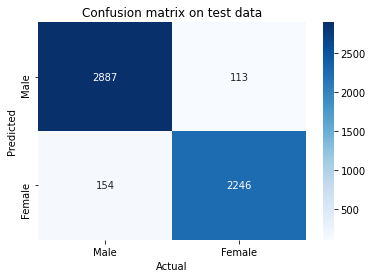

In [ ]:
#plot confusion matrix

cm = pd.DataFrame(confusion_matrix(y_test_int,gender_y_preds) , index = ['Male', 'Female'] , columns = ['Male', 'Female'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['Male', 'Female'], yticklabels = ['Male', 'Female'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.show()

In [ ]:
print("Precision:", precision_score(y_test_int,gender_y_preds))
print("Recall:", recall_score(y_test_int,gender_y_preds))
print("F-score:",f1_score(y_test_int,gender_y_preds))

Precision: 0.9520983467571005
Recall: 0.9358333333333333
F-score: 0.9438957764236184


AUC - Test Set: 98.84%


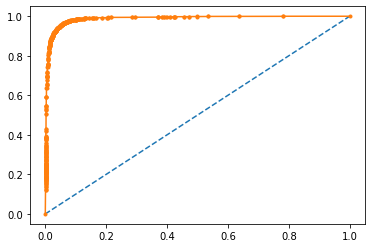

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# predict probabilities
probs = gender_model_loaded.predict(x_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test_int, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test_int, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

# AGE

In [ ]:
def get_np_means(arr):
  return np.mean(arr.T, axis=0)

In [ ]:
age_data = sound_data.copy()

age_data["mfcc"] = age_data["mfcc"].apply(get_np_means)
age_data = age_data.dropna()
age_data.head()

,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,2,0,0.025066,2333.515420,"[-393.8289, 85.47335, 1.4228904, 24.578445, -1...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1,4,1,0.086192,1875.045261,"[-363.5393, 78.68751, -9.93091, 9.993607, -15....",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
2,2,1,0.002153,3797.429451,"[-708.3258, 44.437115, 37.39505, 11.696047, -2...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
3,6,0,0.009721,2595.827243,"[-529.4351, 81.02429, 5.8359385, 28.622475, -8...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
4,3,0,0.013881,2043.898864,"[-516.62335, 108.33303, 18.175974, 20.33933, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


In [ ]:
indexNames = age_data[ (age_data['gender'] == 0)].index
age_data.drop(indexNames[:36000] , inplace=True)
age_data['gender'].value_counts()

0    18148
1    18080
Name: gender, dtype: int64

In [ ]:
age_data['age'].value_counts()

1    10230
2     9024
4     6104
3     5028
5     2682
0     2471
6      593
7       96
Name: age, dtype: int64

In [ ]:
age_data.drop(age_data[age_data.age == 6].index, inplace=True)
age_data.drop(age_data[age_data.age == 7].index, inplace=True)

In [ ]:
for i in range(6):
  current = len(age_data[age_data.age == i])
  desired = 4500
  cut = current - desired
  if cut > 0:
    maleIndexNames = age_data[ (age_data['age'] == i) & (age_data['gender'] == 0)].index
    femaleIndexNames = age_data[ (age_data['age'] == i) & (age_data['gender'] == 1)].index
    if len(femaleIndexNames) > desired//2:
      age_data.drop(femaleIndexNames[:abs(desired//2 -len(femaleIndexNames))] , inplace=True)
      cut = cut - abs((desired//2)-len(femaleIndexNames))
    age_data.drop(maleIndexNames[:cut] , inplace=True)
age_data['age'].value_counts()

3    4500
2    4500
1    4500
4    2851
5    2682
0    2471
Name: age, dtype: int64

In [ ]:
for i in range(6):
  indexNames = age_data[ (age_data['age'] == i) & (age_data['gender'] == 0)].index
  indexNamesf = age_data[ (age_data['age'] == i) & (age_data['gender'] == 1)].index
  print("Males: " + str(len(indexNames)))
  print("Females: " + str(len(indexNamesf)))
  print()

Males: 1413
Females: 1058

Males: 2250
Females: 2250

Males: 2250
Females: 2250

Males: 2313
Females: 2187

Males: 601
Females: 2250

Males: 963
Females: 1719



In [ ]:
age_ys_df = pd.get_dummies(age_data["age"], prefix="age")
age_ys_df.head(5)

,age_0,age_1,age_2,age_3,age_4,age_5
44,0,0,0,1,0,0
50,0,0,0,1,0,0
51,0,0,0,1,0,0
75,1,0,0,0,0,0
92,0,0,0,1,0,0


In [ ]:
age_data = age_data.drop(columns=["age"])
age_data.head(5)

,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
44,1,0.006296,2930.092320,"[-512.1549, 65.49924, 1.359963, 11.318239, -0....",187.563216,0.273815,0.546031,"[0.6981892, 0.7123283, 0.7046953, 0.66937, 0.6...","[1.5332462e-05, 1.3674874e-05, 8.266537e-05, 0..."
50,1,0.024973,3516.275504,"[-360.4243, 54.532433, 15.547078, 8.089113, 11...",228.571477,0.821133,3.066960,"[0.5683182, 0.40421742, 0.37432155, 0.39280963...","[0.0023872845, 0.0021968444, 0.0055818395, 0.0..."
51,1,0.010441,2786.693772,"[-512.9718, 91.92638, -11.501456, 6.186752, -5...",174.858184,0.541940,0.851518,"[0.6921396, 0.6236112, 0.60554373, 0.5524804, ...","[0.00012817298, 8.79001e-05, 9.209417e-05, 0.0..."
75,1,0.056670,1454.101620,"[-386.14594, 100.48273, 7.7905064, 17.722294, ...",249.443866,0.520431,1.111310,"[0.33956286, 0.34799302, 0.49417365, 0.4560578...","[0.0043000397, 0.005142193, 0.012556154, 0.022..."
92,1,0.064136,2744.827845,"[-276.8076, 68.596924, -20.012516, 16.66164, -...",309.246857,3.050315,5.980916,"[0.3965203, 0.36441055, 0.4757664, 0.4617416, ...","[0.0043009794, 0.00484432, 0.010444291, 0.0555..."


In [ ]:
single_data_columns = ["gender","mean_RMSE","mean_spec_centroid","meanff","q1","iqr"]

combined = age_data[single_data_columns].values
# print(combined)


age_xs = []

for i in range(age_data.shape[0]):
  mfcc = age_data["mfcc"].iloc[i]
  chroma = age_data["chroma"].iloc[i]
  mel = age_data["mel"].iloc[i]
  combined_stats = combined[i]

  age_xs.append(np.concatenate((
      combined_stats,
      mfcc,
      chroma,
      mel), axis=0))
  
age_xs = np.array(age_xs)
print(age_xs)
print(age_xs.shape)

[[1 0.006295983679592609 2930.0923195310284 ... 1.0465222658240236e-05
  2.8806994123442564e-06 3.3859802783808846e-07]
 [1 0.024973027408123016 3516.275504453891 ... 0.00021037769329268485
  0.00010749218927230686 8.386889930989128e-06]
 [1 0.010441149584949017 2786.693771812362 ... 0.001226857304573059
  0.000296704558422789 7.596064824610949e-05]
 ...
 [0 0.03496934846043587 2090.021721511013 ... 0.0003399355337023735
  9.07320500118658e-05 7.506826477765571e-06]
 [1 0.027498988434672356 2479.9961540966024 ... 0.00048567826161161065
  9.983278869185597e-05 4.511646238825051e-06]
 [0 0.006606015842407942 2154.427486353898 ... 7.34049251605029e-07
  2.2672325883377198e-07 1.4870818354495441e-08]]
(21504, 166)


In [ ]:
age_ys = age_ys_df.values

In [ ]:
age_x_train, age_x_test, age_y_train, age_y_test = train_test_split(age_xs, age_ys, test_size=0.2, random_state=5)

In [ ]:
age_ss = StandardScaler()
age_x_train = age_ss.fit_transform(age_x_train)
age_x_test = age_ss.transform(age_x_test)

In [ ]:
from sklearn.externals.joblib import dump, load
dump(age_ss, 'std_scaler_age_6.bin', compress=True)

['std_scaler_age_6.bin']

In [ ]:
age_ys_df.value_counts()

age_0  age_1  age_2  age_3  age_4  age_5
1      0      0      0      0      0        4500
0      1      0      0      0      0        4500
       0      1      0      0      0        4500
              0      1      0      0        4500
                     0      1      0        4500
                            0      1        4500
dtype: int64

In [ ]:
print(np.isnan(age_x_train).any())
age_x_train.shape

False


(21600, 166)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

age_model = Sequential()
age_model.add(Dense(166, input_shape=(166,), activation = 'relu'))
age_model.add(Dropout(0.1))
age_model.add(Dense(1024, activation = 'relu'))
age_model.add(Dropout(0.25))
age_model.add(Dense(1024, activation = 'relu'))
age_model.add(Dropout(0.25))
age_model.add(Dense(1024, activation = 'relu'))
age_model.add(Dropout(0.25))
age_model.add(Dense(1024, activation = 'relu'))
age_model.add(Dense(6, activation = 'softmax'))

age_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')

In [ ]:
age_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 166)               27722     
_________________________________________________________________
dropout_32 (Dropout)         (None, 166)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1024)              171008    
_________________________________________________________________
dropout_33 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_34 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 1024)             

In [ ]:
history = age_model.fit(age_x_train, age_y_train, batch_size=36, epochs=120, 
                    validation_split=0.2,
                    callbacks=[early_stop])

Epoch 1/120
480/480 [==============================] - 31s 62ms/step - loss: 1.7044 - accuracy: 0.2840 - val_loss: 1.3512 - val_accuracy: 0.4637
Epoch 2/120
480/480 [==============================] - 30s 63ms/step - loss: 1.3393 - accuracy: 0.4771 - val_loss: 1.1805 - val_accuracy: 0.5465
Epoch 3/120
480/480 [==============================] - 30s 62ms/step - loss: 1.1431 - accuracy: 0.5662 - val_loss: 1.0693 - val_accuracy: 0.5926
Epoch 4/120
480/480 [==============================] - 30s 62ms/step - loss: 1.0195 - accuracy: 0.6201 - val_loss: 0.9894 - val_accuracy: 0.6299
Epoch 5/120
480/480 [==============================] - 29s 61ms/step - loss: 0.8933 - accuracy: 0.6728 - val_loss: 0.9038 - val_accuracy: 0.6764
Epoch 6/120
480/480 [==============================] - 30s 62ms/step - loss: 0.8030 - accuracy: 0.7061 - val_loss: 0.8434 - val_accuracy: 0.6917
Epoch 7/120
480/480 [==============================] - 30s 63ms/step - loss: 0.7302 - accuracy: 0.7310 - val_loss: 0.8033 - val_ac

In [ ]:
age_model.save("./cnn_age_model_6.h5")

In [ ]:
age_model_loaded = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Code for submission/Saved Models/cnn_age_model_6.h5")


In [ ]:
age_model_loaded.evaluate(age_x_test,age_y_test)

169/169 [==============================] - 2s 9ms/step - loss: 0.6362 - accuracy: 0.7904


[0.6362470984458923, 0.7903703451156616]

In [ ]:
results = age_model_loaded.predict_classes(age_x_test)
print(results[:20])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[3 1 0 3 4 0 4 5 4 5 4 5 5 5 4 1 0 0 5 5]


In [ ]:
age_y_preds = age_model_loaded.predict_classes(age_x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# convert y_test from one-hot encoding to integers
age_y_test_int = np.argmax(age_y_test, axis=1)

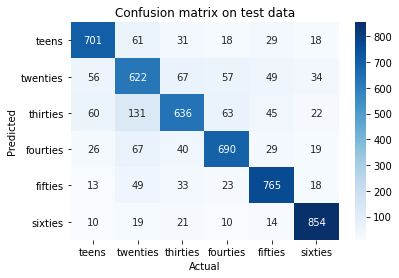

In [ ]:
#plot confusion matrix for age

cm = pd.DataFrame(confusion_matrix(age_y_test_int,age_y_preds) , index = ['teens','twenties','thirties','fourties','fifties','sixties'] , columns = ['teens','twenties','thirties','fourties','fifties','sixties'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['teens','twenties','thirties','fourties','fifties','sixties'], yticklabels = ['teens','twenties','thirties','fourties','fifties','sixties'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.show()

In [ ]:
print("Precision:", precision_score(age_y_test_int,age_y_preds,average=None))
print("Recall:", recall_score(age_y_test_int,age_y_preds,average=None))
print("F-score:",f1_score(age_y_test_int,age_y_preds,average=None))

Precision: [0.80946882 0.65542677 0.76811594 0.80139373 0.8216971  0.88497409]
Recall: [0.81701632 0.70282486 0.6645768  0.79219288 0.8490566  0.92025862]
F-score: [0.81322506 0.6782988  0.71260504 0.79676674 0.83515284 0.90227153]


In [ ]:
print("Precision:", precision_score(age_y_test_int,age_y_preds,average="weighted"))
print("Recall:", recall_score(age_y_test_int,age_y_preds,average="weighted"))
print("F-score:",f1_score(age_y_test_int,age_y_preds,average="weighted"))

Precision: 0.790607939966303
Recall: 0.7903703703703704
F-score: 0.7895868669004452


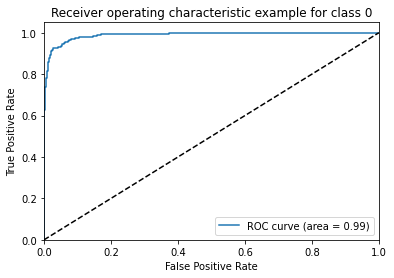

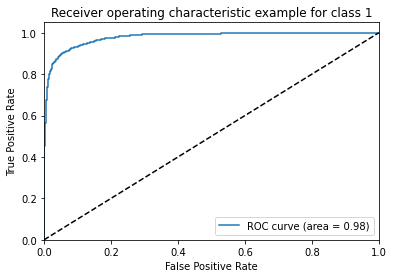

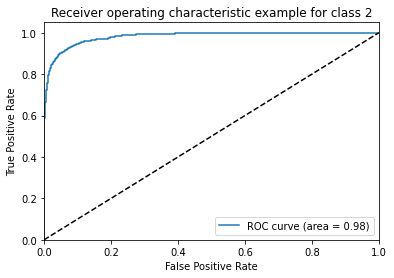

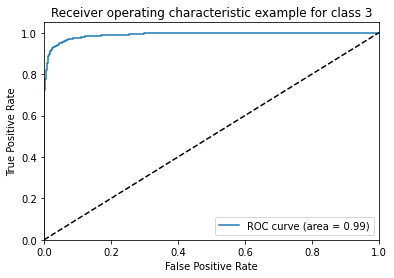

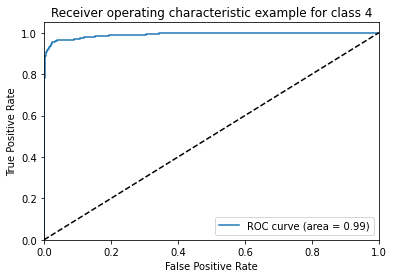

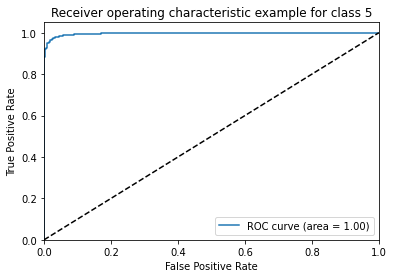

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
y_test_int = label_binarize(age_y_test_int, classes=[0,1,2,3,4,5])
n_classes = 6

y_score = age_model_loaded.predict(age_x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_int[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example for class ' + str(i))
    plt.legend(loc="lower right")
    plt.show()

# Joint Classification

In [ ]:
joint_data = sound_data.copy()

joint_data["mfcc"] = joint_data["mfcc"].apply(get_np_means)
joint_data = joint_data.dropna()

In [ ]:
joint_data.head()

,age,gender,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
0,2,0,0.025066,2333.515420,"[-393.8289, 85.47335, 1.4228904, 24.578445, -1...",178.808002,0.409884,1.012415,"[0.675646, 0.7073074, 0.61221164, 0.6449339, 0...","[0.0029826183, 0.0051411446, 0.008285743, 0.01..."
1,4,1,0.086192,1875.045261,"[-363.5393, 78.68751, -9.93091, 9.993607, -15....",381.535309,0.782728,1.497800,"[0.5251165, 0.53022057, 0.5565261, 0.5294604, ...","[0.039002493, 0.20496942, 4.5200353, 11.305368..."
2,2,1,0.002153,3797.429451,"[-708.3258, 44.437115, 37.39505, 11.696047, -2...",239.809806,0.079895,0.135348,"[0.6472252, 0.6041823, 0.6314197, 0.62660223, ...","[9.714776e-06, 5.468462e-06, 5.4659545e-06, 6...."
3,6,0,0.009721,2595.827243,"[-529.4351, 81.02429, 5.8359385, 28.622475, -8...",126.877179,1.101018,1.920628,"[0.59890276, 0.58788294, 0.5915688, 0.59512645...","[0.00011609932, 0.00013558251, 0.00068590173, ..."
4,3,0,0.013881,2043.898864,"[-516.62335, 108.33303, 18.175974, 20.33933, -...",140.803452,0.964515,1.134937,"[0.6100764, 0.6250077, 0.68134856, 0.71180815,...","[0.0014744281, 0.0017879839, 0.02412793, 0.357..."


In [ ]:
joint_data.groupby(["age", "gender"]).size()

age  gender
0    0          4199
     1          1058
1    0         18376
     1          3955
2    0         13524
     1          4558
3    0          8600
     1          2187
4    0          4933
     1          4455
5    0          2824
     1          1719
6    0          1471
     1           130
7    0           221
     1            18
dtype: int64

In [ ]:
joint_data.drop(joint_data[joint_data.age == 6].index, inplace=True)
joint_data.drop(joint_data[joint_data.age == 7].index, inplace=True)

In [ ]:
desired = 1500

for i in range(6):
  for j in range(2):
    current = len(joint_data[(joint_data.age == i) & (joint_data.gender == j)])
    cut = current - desired
    if cut > 0:
      indexNames = joint_data[ (joint_data.age == i) & (joint_data.gender == j)].index
      joint_data.drop(indexNames[:cut] , inplace=True)

joint_data.groupby(["age", "gender"]).size()

age  gender
0    0         1500
     1         1058
1    0         1500
     1         1500
2    0         1500
     1         1500
3    0         1500
     1         1500
4    0         1500
     1         1500
5    0         1500
     1         1500
dtype: int64

In [ ]:
joint_ys_raw = joint_data.apply(lambda row: 2*row.age + row.gender, axis=1)

In [ ]:
joint_ys_df = pd.get_dummies(joint_ys_raw, prefix="gender_age")
joint_ys_df.head(5)

,gender_age_0,gender_age_1,gender_age_2,gender_age_3,gender_age_4,gender_age_5,gender_age_6,gender_age_7,gender_age_8,gender_age_9,gender_age_10,gender_age_11
75,0,1,0,0,0,0,0,0,0,0,0,0
102,0,1,0,0,0,0,0,0,0,0,0,0
112,0,1,0,0,0,0,0,0,0,0,0,0
126,0,1,0,0,0,0,0,0,0,0,0,0
317,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
joint_data = joint_data.drop(columns=["age","gender"])
joint_data.head(5)

,mean_RMSE,mean_spec_centroid,mfcc,meanff,q1,iqr,chroma,mel
75,0.056670,1454.101620,"[-386.14594, 100.48273, 7.7905064, 17.722294, ...",249.443866,0.520431,1.111310,"[0.33956286, 0.34799302, 0.49417365, 0.4560578...","[0.0043000397, 0.005142193, 0.012556154, 0.022..."
102,0.132965,1883.154216,"[-247.03949, 107.16333, 8.975393, 23.24266, 11...",143.466134,3.774730,9.108865,"[0.54969305, 0.44200122, 0.426685, 0.4364752, ...","[0.06668752, 0.060265932, 0.23155582, 8.768757..."
112,0.168267,1517.614402,"[-281.86047, 113.006874, -7.760749, 21.788141,...",219.979231,1.738092,3.834813,"[0.3571549, 0.543462, 0.5328238, 0.45858684, 0...","[0.09858959, 0.06376005, 0.07613839, 0.1897855..."
126,0.037543,2073.744516,"[-343.83975, 94.316734, -25.391293, -1.0836291...",257.940917,0.457648,0.872676,"[0.713621, 0.58126193, 0.5259735, 0.5297548, 0...","[8.405133e-05, 0.0001460577, 0.0001727827, 0.0..."
317,0.102688,3522.181557,"[-258.00665, 53.81378, 39.28914, 3.4949138, -4...",252.771954,5.077357,13.650152,"[0.54590243, 0.4162665, 0.33224532, 0.3178428,...","[0.020623105, 0.016758563, 0.012980731, 0.0387..."


In [ ]:
single_data_columns = ["mean_RMSE","mean_spec_centroid","meanff","q1","iqr"]

combined = joint_data[single_data_columns].values

joint_xs = []

for i in range(joint_data.shape[0]):
  mfcc = joint_data["mfcc"].iloc[i]
  chroma = joint_data["chroma"].iloc[i]
  mel = joint_data["mel"].iloc[i]
  combined_stats = combined[i]

  joint_xs.append(np.concatenate((
      combined_stats,
      mfcc,
      chroma,
      mel), axis=0))
  
joint_xs = np.array(joint_xs)
print(joint_xs)
print(joint_xs.shape)

[[5.66704199e-02 1.45410162e+03 2.49443866e+02 ... 1.30996023e-08
  3.77776654e-09 4.79088713e-10]
 [1.32965460e-01 1.88315422e+03 1.43466134e+02 ... 6.68677175e-03
  5.01428964e-03 4.80642921e-04]
 [1.68266624e-01 1.51761440e+03 2.19979231e+02 ... 5.86939791e-07
  1.47259570e-07 1.35399993e-08]
 ...
 [3.49693485e-02 2.09002172e+03 1.31681293e+02 ... 3.39935534e-04
  9.07320500e-05 7.50682648e-06]
 [2.74989884e-02 2.47999615e+03 2.17378584e+02 ... 4.85678262e-04
  9.98327887e-05 4.51164624e-06]
 [6.60601584e-03 2.15442749e+03 1.24400531e+02 ... 7.34049252e-07
  2.26723259e-07 1.48708184e-08]]
(17558, 165)


In [ ]:
joint_ys = joint_ys_df.values

In [ ]:
joint_x_train, joint_x_test, joint_y_train, joint_y_test = train_test_split(joint_xs, joint_ys, test_size=0.2, random_state=5)

In [ ]:
joint_ss = StandardScaler()
joint_x_train = joint_ss.fit_transform(joint_x_train)
joint_x_test = joint_ss.transform(joint_x_test)

In [ ]:
dump(joint_ss, 'std_scaler_joint_3.bin', compress=True)

['std_scaler_joint_3.bin']

In [ ]:
print(np.isnan(joint_x_train).any())
joint_ys[0]

False


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

joint_model = Sequential()
joint_model.add(Dense(165, input_shape=(165,), activation = 'relu'))
joint_model.add(Dropout(0.1))
joint_model.add(Dense(1024, activation = 'relu'))
joint_model.add(Dropout(0.25))
joint_model.add(Dense(1024, activation = 'relu'))
joint_model.add(Dropout(0.25))
joint_model.add(BatchNormalization())
joint_model.add(Dense(1024, activation = 'relu'))
joint_model.add(Dropout(0.25))
joint_model.add(Dense(1024, activation = 'relu'))
joint_model.add(Dense(12, activation = 'softmax'))

joint_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')

In [ ]:
joint_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 165)               27390     
_________________________________________________________________
dropout_43 (Dropout)         (None, 165)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 1024)              169984    
_________________________________________________________________
dropout_44 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_45 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)            

In [ ]:
history = joint_model.fit(joint_x_train, joint_y_train, batch_size=128, epochs=70, 
                    validation_split=0.2,
                    callbacks=[early_stop])

Epoch 1/70
88/88 [==============================] - 1s 8ms/step - loss: 2.6973 - accuracy: 0.1406 - val_loss: 2.1344 - val_accuracy: 0.2986
Epoch 2/70
88/88 [==============================] - 1s 6ms/step - loss: 2.1661 - accuracy: 0.2376 - val_loss: 1.9130 - val_accuracy: 0.3772
Epoch 3/70
88/88 [==============================] - 1s 6ms/step - loss: 1.9710 - accuracy: 0.2965 - val_loss: 1.7899 - val_accuracy: 0.4114
Epoch 4/70
88/88 [==============================] - 1s 6ms/step - loss: 1.8489 - accuracy: 0.3335 - val_loss: 1.7118 - val_accuracy: 0.4217
Epoch 5/70
88/88 [==============================] - 1s 6ms/step - loss: 1.7316 - accuracy: 0.3868 - val_loss: 1.6290 - val_accuracy: 0.4420
Epoch 6/70
88/88 [==============================] - 1s 6ms/step - loss: 1.6797 - accuracy: 0.4025 - val_loss: 1.5742 - val_accuracy: 0.4733
Epoch 7/70
88/88 [==============================] - 1s 6ms/step - loss: 1.6094 - accuracy: 0.4152 - val_loss: 1.5122 - val_accuracy: 0.4982
Epoch 8/70
88/88 [==

In [ ]:
joint_model.save("./cnn_joint_model_3.h5")

In [ ]:
joint_model_loaded = keras.models.load_model("./cnn_joint_model_3.h5")

In [ ]:
joint_model_loaded.evaluate(joint_x_test,joint_y_test)

110/110 [==============================] - 1s 10ms/step - loss: 0.9294 - accuracy: 0.7281


[0.929370105266571, 0.7280751466751099]

In [ ]:
joint_y_preds = joint_model_loaded.predict_classes(joint_x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
joint_y_test_int = np.argmax(joint_y_test, axis=1)

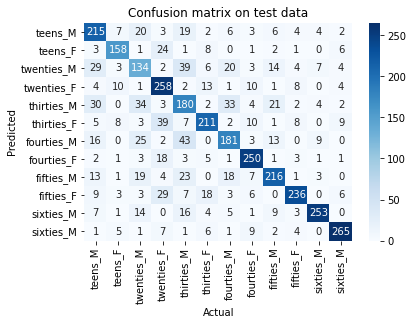

In [ ]:
cm = pd.DataFrame(confusion_matrix(joint_y_test_int,joint_y_preds),
                  index = ['teens_M','teens_F','twenties_M','twenties_F','thirties_M','thirties_F','fourties_M','fourties_F','fifties_M','fifties_F','sixties_M','sixties_M'],
                  columns = ['teens_M','teens_F','twenties_M','twenties_F','thirties_M','thirties_F','fourties_M','fourties_F','fifties_M','fifties_F','sixties_M','sixties_M'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='',
            xticklabels = ['teens_M','teens_F','twenties_M','twenties_F','thirties_M','thirties_F','fourties_M','fourties_F','fifties_M','fifties_F','sixties_M','sixties_M'],
            yticklabels = ['teens_M','teens_F','twenties_M','twenties_F','thirties_M','thirties_F','fourties_M','fourties_F','fifties_M','fifties_F','sixties_M','sixties_M'])

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.show()

In [ ]:
print("Precision:", precision_score(joint_y_test_int,joint_y_preds,average="weighted"))
print("Recall:", recall_score(joint_y_test_int,joint_y_preds,average="weighted"))
print("F-score:",f1_score(joint_y_test_int,joint_y_preds,average="weighted"))

Precision: 0.7348719641751289
Recall: 0.7280751708428246
F-score: 0.7292902186446968
